In [5]:
import csv
import cv2
import matplotlib.pyplot as plt

In [6]:
# Load the BMP image
image_path1 = '../data/img/2000_LST.bmp'
image_path2 = '../data/img/2010_LST.bmp'

# Create a CSV file to store the pixel color values
csv_path1 = '../data/csv/2000_LST.csv'
csv_path2 = '../data/csv/2010_LST.csv'

image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
h,w = image1.shape[:2]
image2 = cv2.resize(image2, (w, h))
image1.shape[:2], image2.shape[:2]

((1610, 809), (1610, 809))

In [7]:
# Convert the image to grayscale
gray_image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray_image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
# Get the dimensions of the grayscale image
h1, w1 = gray_image1.shape
h2, w2 = gray_image2.shape
h1, w1, h2, w2

(1610, 809, 1610, 809)

In [8]:
with open(csv_path1, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Row", "Column", "Pixel Value"])  # Write header
    
    # Write pixel color values to CSV
    for row in range(h1):
        for col in range(w1):
            pixel_value1 = gray_image1[row, col]
            writer.writerow([row, col, pixel_value1])

with open(csv_path2, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Row", "Column", "Pixel Value"])  # Write header
    
    # Write pixel color values to CSV
    for row in range(h1):
        for col in range(w1):
            pixel_value2 = gray_image2[row, col]
            writer.writerow([row, col, pixel_value2])

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [10]:
# Read the CSV files
input_df = pd.read_csv('../data/csv/2000_LST.csv')
output_df = pd.read_csv('../data/csv/2010_LST.csv')

# Extract the third column as input and output
input_data = input_df.iloc[:, 2].values
output_data = output_df.iloc[:, 2].values

In [11]:
# Preprocess the data
# (Perform any necessary preprocessing steps such as scaling or normalization here)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.2)

# Reshape the data for LSTM input (assuming 1 feature per timestep)
X_train = np.reshape(X_train, (X_train.shape[0], 1, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 1))

In [12]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, 1)))  # Adjust the number of units (128) as needed
model.add(Dense(1))  # Output layer with 1 unit

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, y_train, epochs=2, batch_size=32)  # Adjust batch_size and epochs as needed

# Evaluate the model
loss = model.evaluate(X_test, y_test)

# Make predictions
predictions = model.predict(X_test)

Epoch 1/2
32563/32563 [==============================] - 123s 4ms/step - loss: 2073.2556
Epoch 2/2
8141/8141 [==============================] - 20s 2ms/step


RMSE: 41.36517636023564


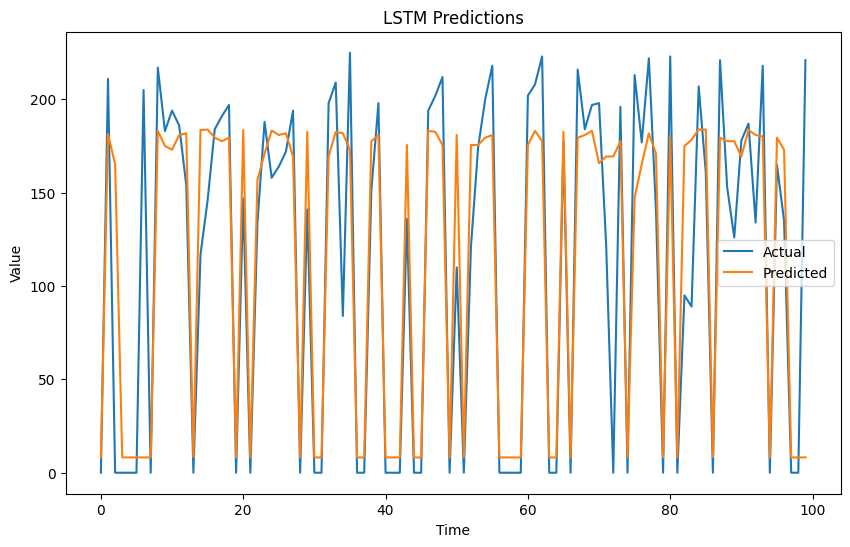

In [15]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

# Visualize the predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test[0:100], label='Actual')
plt.plot(predictions[0:100], label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()